# Prediction of Road Traffic Collision Severity

## Introduction

Road traffic collisions pose a significant safety risk to both drivers and pedestrians. In 2019, the UK saw 1748 deaths and 25,975 serious injuries from road traffic accidents [(source)](https://www.gov.uk/government/statistics/reported-road-casualties-great-britain-provisional-results-2019). Whilst a downward trend has been identified, it is nontheless important to be able to identify predictors of road traffic accidents, for both number of accidents and severity. This is useful for allocation of resources (such as emergency services) - if there are conditions that imply a greater incidence of sever accidents, it may be prudent to increase the number of paramedics on call, for example. 

It is also useful to identify these predictors in order to further reduce the number of severe accidents. Identifying that a particular signage or junction reduces risk allows for local governments to make progressive changes to the road network in order to improve overall safety in the future.

## Data

The data have been sourced from https://www.kaggle.com/akshay4/road-accidents-incidence/. It is an aggregation of year-on-year data published by the United Kingdom Department of Transport. 

The CSV file contains the following fields:

|Field Name|Description|
|----------|-----------|
|Accident_Index|Government ID for incident|
|1st_Road_Class|Classification of road based on [UK numbering scheme](https://en.wikipedia.org/wiki/Great_Britain_road_numbering_scheme)|
|1st_Road_Number|Unique road identifier|
|2nd_Road_Class|Classification of road based on [UK numbering scheme](https://en.wikipedia.org/wiki/Great_Britain_road_numbering_scheme)|
|2nd_Road_Number|Unique road identifier|
|Accident_Severity|Slight, Serious, Fatal|
|Carriageway_Hazards|Potential hazards such as objects in road, animals in road etc.|
|Date|Date of incident|
|Day_of_Week|Day of incident (Mon, Tues, Weds...)|
|Did_Police_Officer_Attend_Scene_of_Accident|Attendance of police|
|Junction_Control|If at junction, what control in place? e.g. traffic light, stop sign etc.|
|Junction_Detail|Additional information about the junction e.g. private drive, staggered etc.|
|Latitude| Geographic coordinate that specifies the north–south position|
|Light_Conditions|Light condition at incident e.g. Light, Dark with no lighting, Dark with street lighting etc.|
|Local_Authority_(District)| Geographic district in which incident occured|
|Local_Authority_(Highway)| Authority responsible for highway|
|Location_Easting_OSGR| Ordnance Survey Grid Reference |
|Location_Northing_OSGR| Ordnance Survey Grid Reference| 
|Longitude| Geographic coordinate that specifies the east-west position|
|LSOA_of_Accident_Location| Lower Super Output Area (ONS statistic reporting area)|
|Number_of_Casualties| How many casualties|
|Number_of_Vehicles| How many vehicles|
|Pedestrian_Crossing-Human_Control| Human controled crossing ('lollipop' person or traffic officer)|
|Pedestrian_Crossing-Physical_Facilities| Pedestrian crossing e.g. zebra crossing, pelican crossing etc.|
|Police_Force|Police force responsible for area of incident|
|Road_Surface_Conditions|Dry, wet, snow etc.|
|Road_Type|Single, dual, roundabout etc.|
|Special_Conditions_at_Site|Roadworks, oil, mud etc.|
|Speed_limit|Speed limit in force at incident location|
|Time|Time of incident|
|Urban_or_Rural_Area|Incident location type (urban or rural)|
|Weather_Conditions|Weather at incident (rain, fog etc)
|Year| Year of incident|
|InScotland|Was the incident in Scotland?

## Proposed Methodology

As there are many predictors, the first step will be cleaning the data and selecting the predictors. It will also be important to identify numeric data and categorical data for the purposes of one-hot encoding.

One issue that is likely to occur is the undersampling of the target categories of interest. We are trying to predict 'Serious' or 'Fatal' accidents, but there are far fewer of these in the dataset which means any models built will have a bias towards predicting severities classified as 'Slight'. 

This could be addressed by downsamplng at random the 'Slight' accidents to have a similar number to the 'Serious' and 'Fatal' accidents. Alternatively there are methods such as the 'Synthetic Minority Over-sampling TEchnique' (SMOTE) which produces synthetic data based on the real data, in order to redress the imbalanced data.

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy.io import shapereader
import geopandas as gpd
import folium
from folium import plugins
import requests
from shapely.geometry import Polygon
import branca
import descartes
from geojson import dump
import geojson
import json

It is best practise to pre-define the expected data-types when reading into a dataframe. This dictionary assigns the column names and data-types so that the `read_csv` method can be executed as efficiently as possible.

In [2]:
column_names = ['1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Year', 'InScotland']
column_types = [str,pd.Int64Dtype(),str,pd.Int64Dtype(),str,str,str,str,pd.Int64Dtype(),
                str,str,float,str,str,str,pd.Int64Dtype(),pd.Int64Dtype(),float,str,pd.Int64Dtype(),
                pd.Int64Dtype(),pd.Int64Dtype(),pd.Int64Dtype(),str,str,str,str,pd.Int64Dtype(),
                str,str,str,pd.Int64Dtype(),str]
traffic_meta_col_types = dict(zip(column_names,column_types))

In [3]:
traffic_data = pd.read_csv('Accident_Information.csv',usecols=column_names,dtype=traffic_meta_col_types)

traffic_data.columns = traffic_data.columns.str.lower()
traffic_data = traffic_data.dropna()
traffic_data = traffic_data[traffic_data['weather_conditions']!='Data missing or out of range']

### Fetching local authority geographic boundaries

In order to investigate spatial trends, it is necessary to get the local authority district (LAD) boundaries. This is freely available [here](https://geoportal.statistics.gov.uk/datasets/54c953ff9b7d463c9d62ac1c1b1806ed). A GeoPandas dataframe is used for easier data manipulation later on.

In [4]:
with open('lad_boundaries.geojson') as f:
    local_authority_geojson = geojson.load(f)
lad_gdf = gpd.GeoDataFrame.from_features(local_authority_geojson['features'])
lad_gdf = lad_gdf.set_crs(local_authority_geojson['crs']['properties']['name'])

The traffic data we have available is for England and Wales only. District codes for these start with 'E' or 'W'.

In [5]:
lad_gdf = lad_gdf.loc[lad_gdf['LAD17CD'].str.startswith('E') | lad_gdf['LAD17CD'].str.startswith('W')]

### Lookup for LSOA

The traffic accident data comes with a code for Lower Layer Super Output Areas (LSOA) - areas defined by the Office for National Statistics for census reporting. In order to map these accurately onto LADs, a lookup table is necessary. This can be found [here](https://geoportal.statistics.gov.uk/datasets/output-area-to-lsoa-to-msoa-to-local-authority-district-december-2017-lookup-with-area-classifications-in-great-britain?orderBy=LSOA11CD). While LAD districts are defined in the accident data, there are minor inconsitencies which introduce complexities later on, so it is best to use this lookup table to ensure the data is consistent and unambiguous. For example, for several incidents, the LAD is reported as 'Heathrow Airport (London)', but geographically they fall within three other LADs.

There are many duplicate rows for the purposes of statistics that aren't relevant to this report, so those are dropped using the `drop_duplicates` method. Then, the useful information is extracted: `LSOA11CD`, `LAD17NM` and `LAD17CD`. These are the LSOA code (as described above), the LAD name and the LAD code respectively.

In [6]:
lsoa_lookup = pd.read_csv('lsoa_lookup.csv')
lsoa_lookup.drop_duplicates('LSOA11CD',inplace=True)
lsoa_lookup = lsoa_lookup[['LSOA11CD','LAD17NM','LAD17CD']]

Now the accident data is left joined with the lookup dataframe. This adds the data with matching LSOA codes from the lookup dataframe into the accident dataframe.

In [7]:
traffic_data = pd.merge(traffic_data,lsoa_lookup,how='left',left_on='lsoa_of_accident_location',right_on='LSOA11CD')
traffic_data.drop(['LSOA11CD'],axis=1,inplace=True)

### Population data
Later on it will be useful to investigate accident rates based on local population. To do this, information on the population in each LAD is necessary. This can be found [here](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/internationalmigration/datasets/populationoftheunitedkingdombycountryofbirthandnationality). However, this population will only be valid for data in 2017; historical population data is available and it would be an interesting future step to investigate spatial trends over time, but beyond the scope of this exercise.

In [8]:
pop_data = pd.read_excel('populationbycountryofbirthandnationalityjan17todec17.xls',sheet_name='1.1',header=8,skipfooter=69,usecols = [0,1,2])

The `xls` file has many blank rows, read in as `NaN` rows. These are dropped using `dropna` with `how='all'` passed.

In [9]:
pop_data.dropna(axis=0, how='all', inplace = True)
pop_data.columns = ['area_code','area_name','population']

In [10]:
pop_data = pop_data[pop_data['population'].apply(lambda x: isinstance(x,int))]

To look at the spatial incidence of traffic accidents, we group by the LAD.

In [19]:
traffic_data_2017 = traffic_data[traffic_data['year']==2017]
td2017_group = pd.DataFrame(traffic_data_2017.groupby('LAD17CD').size())
td2017_group.reset_index(inplace=True)
td2017_group.columns = ['LAD', 'Count']
td2017_group.sort_values(['Count'],ascending=False).head()


,LAD,Count
280,E08000025,1742
325,E09000033,1231
314,E09000022,981
290,E08000035,935
259,E08000003,810


This is combined in a left join with the population data.

In [20]:
td2017_group = pd.merge(td2017_group,pop_data,how='left',left_on='LAD',right_on='area_code')
td2017_group.head()

,LAD,Count,area_code,area_name,population
0,E06000001,68,E06000001,Hartlepool,92
1,E06000002,133,E06000002,Middlesbrough,139
2,E06000003,73,E06000003,Redcar and Cleveland,134
3,E06000004,144,E06000004,Stockton-on-Tees,194
4,E06000005,134,E06000005,Darlington,104


A quirk of the population data is that 'City of London' population is grouped under 'Westminster'. Note that this is the small borough of London with an approximate population of 10,000 not wider area of London itself with a population approaching 8 million. As such, we need to group City of London accident statistics under Westminster statistics for the sake of population analysis. After doing this, we drop the row for City of London.

In [21]:
city_of_london_index = td2017_group.index[td2017_group['LAD']=='E09000001']
westminster_index = td2017_group.index[td2017_group['LAD']=='E09000033']
td2017_group.loc[westminster_index,'Count'] = td2017_group.loc[westminster_index,'Count'].values[0] + td2017_group.loc[city_of_london_index,'Count'].values[0]
td2017_group.drop(axis=0,index=city_of_london_index,inplace=True)

We also need to modify the GeoJson information to combine Westminster and the City of London.

In [14]:
london_index = lad_gdf[lad_gdf['LAD17CD']=='E09000001'].index.values[0]
westminster_index = lad_gdf[lad_gdf['LAD17CD']=='E09000033'].index.values[0]
lad_gdf.loc[westminster_index,'geometry']=lad_gdf[lad_gdf['LAD17CD']=='E09000033']['geometry'].values[0].union(lad_gdf[lad_gdf['LAD17CD']=='E09000001'].values[0][0])
lad_gdf.drop(axis=0,index = london_index,inplace=True)

The main benefit of having population data is so that we can scale the number of accidents by the population of each district. As such, we find the number of accidents per thousand people in each district.

In [22]:
td2017_group['accidents_per_thousand'] = td2017_group['Count']/td2017_group['population']
td2017_group.rename(columns={'LAD':'LAD17CD'},inplace=True)

Left joining again to allow for mouse-over tooltips in the map - this is because tooltip information must be in the geojson data structure.

In [33]:
lad_gdf = pd.merge(lad_gdf,td2017_group,how='left',on='LAD17CD')

To avoid outliers skewing the colour gradient, make the scale between the 5th and 95 percentile.

In [101]:
colour_min = lad_gdf['accidents_per_thousand'].quantile(.05)
colour_max = lad_gdf['accidents_per_thousand'].quantile(.95)

colour_fn = branca.colormap.linear.OrRd_09.scale(colour_min,colour_max)
def style_function(feature):    
    accident_rate = feature['properties']['accidents_per_thousand']
    return {
        'fillOpacity': .7,
        'weight': 0,
        'fillColor': '#black' if accident_rate is None else colour_fn(accident_rate)
    }
ew_coords = [52.45139, -2.618611]
ew_map = folium.Map(location = ew_coords,zoom_start=6)
folium.GeoJson(
    lad_gdf,
    tooltip=folium.features.GeoJsonTooltip(fields=['LAD17NM','accidents_per_thousand'],localize=True),
    style_function = style_function
).add_to(ew_map)
ew_map

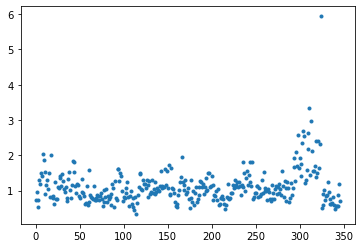

In [83]:
plt.plot(lad_gdf['accidents_per_thousand'],'.')

<AxesSubplot:>

<Figure size 72x144 with 0 Axes>

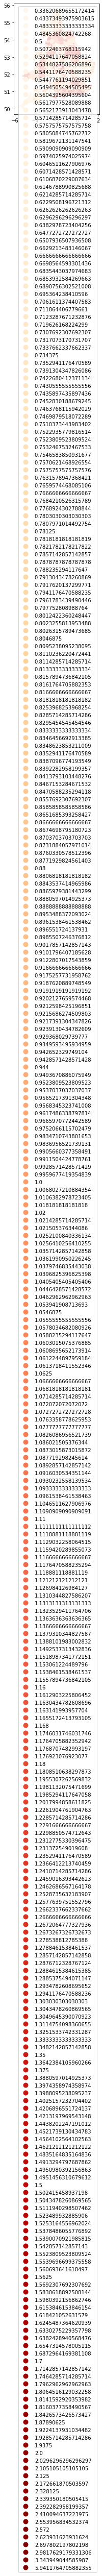

In [78]:
plt.figure(figsize = [1,2])

lad_gdf.plot(column='accidents_per_thousand',cmap='OrRd',legend='True')

In [72]:
td2017_group.head()

,LAD17CD,Count,area_code,LAD17NM,population,accidents_per_thousand
0,E06000001,68,E06000001,Hartlepool,92,0.73913
1,E06000002,133,E06000002,Middlesbrough,139,0.956835
2,E06000003,73,E06000003,Redcar and Cleveland,134,0.544776
3,E06000004,144,E06000004,Stockton-on-Tees,194,0.742268
4,E06000005,134,E06000005,Darlington,104,1.28846


<AxesSubplot:xlabel='LAD17NM', ylabel='accidents_per_thousand'>

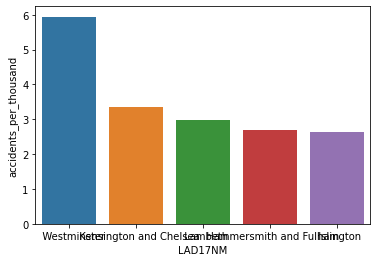

In [78]:
sns.barplot(x='LAD17NM',y='accidents_per_thousand',data= td2017_group.sort_values('accidents_per_thousand',ascending=False).head())

In [150]:
names = [lad['properties']['name'] for lad in lad_geojson['features']]

In [35]:
np.setdiff1d(traffic_data['local_authority_(district)'].unique(),district_names)

array(['Alnwick', 'Berwick-upon-Tweed', 'Blyth Valley', 'Bridgnorth',
       'Caradon', 'Carrick', 'Castle Morpeth', 'Chester',
       'Chester-le-Street', 'Congleton', 'Crewe and Nantwich',
       'Derwentside', 'Durham', 'Easington', 'Edinburgh, City of',
       'Ellesmere Port and Neston', 'Kennet', 'Kerrier',
       'London Airport (Heathrow)', 'Macclesfield', 'Mid Bedfordshire',
       'North Cornwall', 'North Shropshire', 'North Wiltshire',
       'Oswestry', 'Penwith', 'Restormel', 'Rhondda, Cynon, Taff',
       'Salisbury', 'Sedgefield', 'Shrewsbury and Atcham',
       'South Bedfordshire', 'South Shropshire', 'St. Albans',
       'St. Edmundsbury', 'Stratford-upon-Avon', 'Teesdale',
       'The Vale of Glamorgan', 'Tynedale', 'Vale Royal', 'Wansbeck',
       'Wear Valley', 'West Wiltshire'], dtype=object)

In [38]:
len(traffic_data['lsoa_of_accident_location'].unique())

35411

In [36]:
traffic_data[traffic_data['local_authority_(district)']=='Alnwick']['lsoa_of_accident_location'].unique()

array(['E01027361', 'E01027365', 'E01027364', 'E01027358', 'E01027370',
       'E01027373', 'E01027357', 'E01027362', 'E01027359', 'E01027366',
       'E01027356', 'E01027371', 'E01027372', 'E01027374', 'E01027360',
       'E01027368', 'E01027450', 'E01027369', 'E01027367', 'E01027384'],
      dtype=object)

In [169]:
lad_geojson['features'][-1]['properties']['name']['properties']['name']['properties']['name']

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-3.33447027980171, 51.7904023127105],
    [-3.32905965041212, 51.7587227670888],
    [-3.32719971999412, 51.7560165922223],
    [-3.31011259354633, 51.7394551139735],
    [-3.3155115262688, 51.7318086297241],
    [-3.30063731995472, 51.7363143902568],
    [-3.27393042080812, 51.6823368561687],
    [-3.28880375945965, 51.6581946659853],
    [-3.2961098706659, 51.6640939487647],
    [-3.31390702120116, 51.6446795482579],
    [-3.31386165682889, 51.6557042373331],
    [-3.32928092399134, 51.6551179205493],
    [-3.33979709056804, 51.6671582077065],
    [-3.343533235066, 51.6690064989069],
    [-3.36750452601997, 51.6985942897289],
    [-3.38060386905553, 51.7113729608178],
    [-3.40543487942681, 51.722603141292],
    [-3.41489007626581, 51.7362734784998],
    [-3.42368565312519, 51.742286085438],
    [-3.44256033671111, 51.755667719152],
    [-3.45010157996539, 51.7623996978098],
    [-3.4274715156293, 51.7584982957

In [20]:
sorted(traffic_data['local_authority_(district)'].unique())

['Adur',
 'Allerdale',
 'Alnwick',
 'Amber Valley',
 'Arun',
 'Ashfield',
 'Ashford',
 'Aylesbury Vale',
 'Babergh',
 'Barking and Dagenham',
 'Barnet',
 'Barnsley',
 'Barrow-in-Furness',
 'Basildon',
 'Basingstoke and Deane',
 'Bassetlaw',
 'Bath and North East Somerset',
 'Bedford',
 'Berwick-upon-Tweed',
 'Bexley',
 'Birmingham',
 'Blaby',
 'Blackburn with Darwen',
 'Blackpool',
 'Blaenau Gwent',
 'Blyth Valley',
 'Bolsover',
 'Bolton',
 'Boston',
 'Bournemouth',
 'Bracknell Forest',
 'Bradford',
 'Braintree',
 'Breckland',
 'Brent',
 'Brentwood',
 'Bridgend',
 'Bridgnorth',
 'Brighton and Hove',
 'Bristol, City of',
 'Broadland',
 'Bromley',
 'Bromsgrove',
 'Broxbourne',
 'Broxtowe',
 'Burnley',
 'Bury',
 'Caerphilly',
 'Calderdale',
 'Cambridge',
 'Camden',
 'Cannock Chase',
 'Canterbury',
 'Caradon',
 'Cardiff',
 'Carlisle',
 'Carmarthenshire',
 'Carrick',
 'Castle Morpeth',
 'Castle Point',
 'Central Bedfordshire',
 'Ceredigion',
 'Charnwood',
 'Chelmsford',
 'Cheltenham',
 'Che

In [156]:
np.setdiff1d(names,sorted(traffic_data['local_authority_(district)'].unique()))

TypeError: '<' not supported between instances of 'dict' and 'str'

In [25]:
[traffic_data['Latitude'],traffic_data['Longitude']]

[0          51.489096
 1          51.520075
 2          51.525301
 3          51.482442
 4          51.495752
              ...    
 2047251    55.311793
 2047252    54.994285
 2047253    55.053767
 2047254    55.326392
 2047255    54.989905
 Name: Latitude, Length: 2047256, dtype: float64,
 0         -0.191170
 1         -0.211708
 2         -0.206458
 3         -0.173862
 4         -0.156618
              ...   
 2047251   -3.450645
 2047252   -3.067116
 2047253   -3.225506
 2047254   -3.412672
 2047255   -3.272073
 Name: Longitude, Length: 2047256, dtype: float64]

In [11]:
traffic_data.columns

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')

In [3]:
traffic_data.columns = traffic_data.columns.str.lower()
traffic_data = traffic_data.dropna()
traffic_data = traffic_data[traffic_data['weather_conditions']!='Data missing or out of range']

In [68]:
traffic_data['InScotland'].value_counts()

No     1913224
Yes     133979
Name: InScotland, dtype: int64

In [45]:
np.setdiff1d(traffic_data['Local_Authority_(Highway)'],traffic_data['Local_Authority_(District)'])

array(['Argyll & Bute', 'Buckinghamshire', 'Cambridgeshire', 'Cumbria',
       'Derbyshire', 'Devon', 'Dorset', 'Dumfries & Galloway',
       'East Sussex', 'Essex', 'Gloucestershire', 'Hampshire',
       'Hertfordshire', 'Isles of Scilly', 'Kent', 'Lancashire',
       'Leicestershire', 'Lincolnshire',
       'Na h-Eileanan an Iar (Western Isles)', 'Norfolk',
       'North Yorkshire', 'Northamptonshire', 'Nottinghamshire',
       'Oxfordshire', 'Somerset', 'Staffordshire', 'Suffolk', 'Surrey',
       'Warwickshire', 'West Sussex', 'Worcestershire'], dtype=object)

In [46]:
np.setdiff1d(traffic_data['Local_Authority_(District)'],traffic_data['Local_Authority_(Highway)'])

array(['Adur', 'Allerdale', 'Alnwick', 'Amber Valley', 'Argyll and Bute',
       'Arun', 'Ashfield', 'Ashford', 'Aylesbury Vale', 'Babergh',
       'Barrow-in-Furness', 'Basildon', 'Basingstoke and Deane',
       'Bassetlaw', 'Berwick-upon-Tweed', 'Blaby', 'Blyth Valley',
       'Bolsover', 'Boston', 'Braintree', 'Breckland', 'Brentwood',
       'Bridgnorth', 'Broadland', 'Bromsgrove', 'Broxbourne', 'Broxtowe',
       'Burnley', 'Cambridge', 'Cannock Chase', 'Canterbury', 'Caradon',
       'Carlisle', 'Carrick', 'Castle Morpeth', 'Castle Point',
       'Charnwood', 'Chelmsford', 'Cheltenham', 'Cherwell', 'Chester',
       'Chester-le-Street', 'Chesterfield', 'Chichester', 'Chiltern',
       'Chorley', 'Christchurch', 'Colchester', 'Congleton', 'Copeland',
       'Corby', 'Cotswold', 'Craven', 'Crawley', 'Crewe and Nantwich',
       'Dacorum', 'Dartford', 'Daventry', 'Derbyshire Dales',
       'Derwentside', 'Dover', 'Dumfries and Galloway', 'Durham',
       'Easington', 'East Cambridge

In [52]:
traffic_data[traffic_data['Local_Authority_(District)']=='West Wiltshire']['Date']

172668    2005-01-03
172669    2005-01-10
172670    2005-01-15
172671    2005-01-31
172672    2005-02-03
             ...    
883144    2009-03-19
883145    2009-03-19
883146    2009-03-20
883147    2009-03-23
883148    2009-03-26
Name: Date, Length: 1155, dtype: object

In [4]:
traffic_data['datetime'] = pd.to_datetime(traffic_data['date'] + ' ' + traffic_data['time'])

In [39]:
traffic_data['hour'] = traffic_data['datetime'].dt.hour
traffic_data['month'] = traffic_data['datetime'].dt.month
traffic_data['year'] = traffic_data['datetime'].dt.year

In [189]:
categorical_predictors = ['hour','month','1st_road_class','day_of_week','weather_conditions','speed_limit','urban_or_rural_area','road_type','light_conditions']
target_label = ['accident_severity']

In [168]:
for col in categorical_predictors + target:
    traffic_data[col] = traffic_data[col].astype('category')


In [217]:
traffic_model = traffic_data[categorical_predictors+target_label].copy()
traffic_model.shape

(1129910, 10)

In [225]:
dummies = pd.get_dummies(traffic_model[categorical_predictors],drop_first=True)
traffic_model = dummies.join(traffic_model[target_label])
traffic_model.shape

(1129910, 71)

In [226]:
features = traffic_model.drop(['accident_severity'],axis=1)
target = traffic_model[['accident_severity']]

In [227]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size = 0.3)

In [224]:
dummies.join(traffic_model[target_label])

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,road_type_One way street,road_type_Roundabout,road_type_Single carriageway,road_type_Slip road,road_type_Unknown,light_conditions_Darkness - lights lit,light_conditions_Darkness - lights unlit,light_conditions_Darkness - no lighting,light_conditions_Daylight,accident_severity
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,Slight
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,Slight
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,Slight
9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Slight
10,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,Slight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040128,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Slight
2040130,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Slight
2040138,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Serious
2040140,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Slight


In [228]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [229]:
y_test_preds  = tree_model.predict(X_test)

In [231]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_test_preds)

In [232]:
print('Classification Report Random Forest - with Entropy and class_weight Parameter: \n', report)

Classification Report Random Forest - with Entropy and class_weight Parameter: 
               precision    recall  f1-score   support

       Fatal       0.02      0.01      0.01      2591
     Serious       0.14      0.06      0.08     41949
      Slight       0.87      0.95      0.91    294433

    accuracy                           0.83    338973
   macro avg       0.34      0.34      0.33    338973
weighted avg       0.77      0.83      0.80    338973



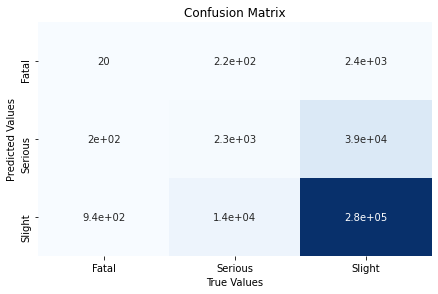

In [235]:
matrix = confusion_matrix(y_test, y_test_preds)
class_names = traffic_model['accident_severity'].values
dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                         columns=['Fatal', 'Serious', 'Slight'])

sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()

In [94]:
traffic_weather_severity = traffic_data[['weather_conditions','accident_severity']]
weather_counts = {}
weather_counts['condition'] = []
weather_counts['total']     = []
weather_counts['fatal']     = []
weather_counts['serious']   = []
weather_counts['slight']    = []
for i,value in enumerate(traffic_weather_severity['weather_conditions'].unique()):
    weather_condition_mask = traffic_weather_severity['weather_conditions']==value
    severity_counts = traffic_weather_severity[weather_condition_mask].value_counts()
    total_accidents = len(traffic_weather_severity[weather_condition_mask])
    weather_counts['condition'].append(value)
    weather_counts['total'].append(total_accidents)
    weather_counts['fatal'].append(severity_counts[value,'Fatal']/total_accidents)
    weather_counts['serious'].append(severity_counts[value,'Serious']/total_accidents)
    weather_counts['slight'].append(severity_counts[value,'Slight']/total_accidents)
    
weather_counts = pd.DataFrame(weather_counts)

<AxesSubplot:xlabel='condition'>

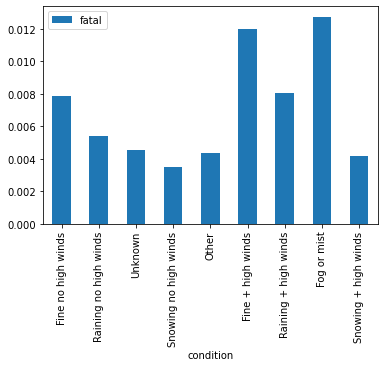

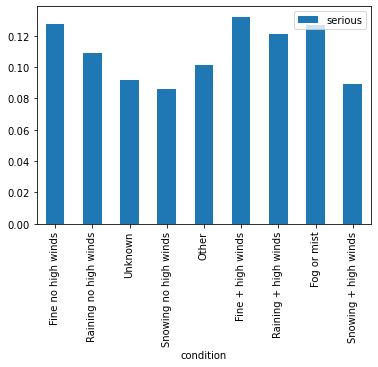

In [109]:
weather_counts.plot.bar(x = 'condition',y=['fatal'])
weather_counts.plot.bar(x = 'condition',y=['serious'])

In [110]:
weather_counts

,condition,total,fatal,serious,slight
0,Fine no high winds,921688,0.007878,0.127270,0.864852
1,Raining no high winds,126797,0.005394,0.108993,0.885612
2,Unknown,22863,0.004549,0.091589,0.903862
3,Snowing no high winds,5476,0.003470,0.086194,0.910336
4,Other,22326,0.004345,0.101138,0.894518
5,Fine + high winds,12595,0.011989,0.132116,0.855895
6,Raining + high winds,12583,0.008027,0.121036,0.870937
7,Fog or mist,4864,0.012747,0.126439,0.860814
8,Snowing + high winds,718,0.004178,0.089136,0.906685


In [28]:
weather_labels = ['Fine no high winds',   #1
                  'Raining no high winds',#2
                  'Snowing no high winds',#3
                  'Fine + high winds',    #4
                  'Raining + high winds', #5
                  'Snowing + high winds', #6
                  'Fog or mist',          #7
                  'Other'                 #8
                  'Unknown']              #9
traffic_data_fatal['weather_conditions'].value_counts().plot.bar()

accident_index                        2988
vehicle_reference                     2988
vehicle_type                          2988
towing_and_articulation               2988
vehicle_manoeuvre                     2988
                                      ... 
bus_or_coach_passenger                2313
pedestrian_road_maintenance_worker    2313
casualty_type                         2313
casualty_home_area_type               2313
casualty_imd_decile                   2313
Length: 70, dtype: int64

In [75]:
traffic_data_fatal['weather_conditions'].value_counts().plot.bar()

106870

In [14]:
traffic_data.columns

Index(['accident_index', '1st_road_class', '1st_road_number', '2nd_road_class',
       '2nd_road_number', 'accident_severity', 'carriageway_hazards', 'date',
       'day_of_week', 'did_police_officer_attend_scene_of_accident',
       'junction_control', 'junction_detail', 'latitude', 'light_conditions',
       'local_authority_(district)', 'local_authority_(highway)',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'lsoa_of_accident_location', 'number_of_casualties',
       'number_of_vehicles', 'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'police_force',
       'road_surface_conditions', 'road_type', 'special_conditions_at_site',
       'speed_limit', 'time', 'urban_or_rural_area', 'weather_conditions',
       'year', 'inscotland', 'datetime', 'hour'],
      dtype='object')

<AxesSubplot:>

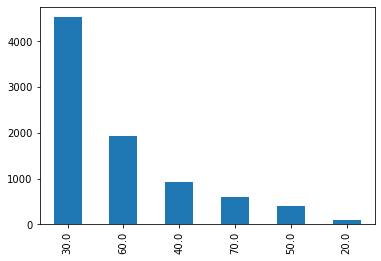

In [25]:
traffic_data_fatal['speed_limit'].value_counts().plot.bar()

In [37]:
traffic_data[traffic_data['local_authority_(district)']!=traffic_data['local_authority_(highway)']]['local_authority_(highway)'].unique()

array(['Cumbria', 'Lancashire', 'Cheshire West and Chester',
       'Cheshire East', 'Northumberland', 'County Durham',
       'North Yorkshire', 'Staffordshire', 'Worcestershire', 'Shropshire',
       'Warwickshire', 'Derbyshire', 'Nottinghamshire', 'Lincolnshire',
       'Leicestershire', 'Northamptonshire', 'Cambridgeshire', 'Norfolk',
       'Suffolk', 'Central Bedfordshire', 'Hertfordshire', 'Essex',
       'Buckinghamshire', 'Oxfordshire', 'Hampshire', 'Surrey', 'Kent',
       'West Sussex', 'East Sussex', 'Cornwall', 'Devon', 'Somerset',
       'Gloucestershire', 'Wiltshire', 'Dorset', 'Isles of Scilly',
       'Blackburn with Darwen'], dtype=object)

,accident_index,1st_road_class,1st_road_number,2nd_road_class,2nd_road_number,accident_severity,carriageway_hazards,date,day_of_week,did_police_officer_attend_scene_of_accident,...,road_type,special_conditions_at_site,speed_limit,time,urban_or_rural_area,weather_conditions,year,inscotland,datetime,hour
734526,2008950010996,A,701.0,C,0.0,Slight,None,2008-12-15,Monday,2.0,...,Single carriageway,None,30.0,11:20,Rural,Raining no high winds,2008,No,2008-12-15 11:20:00,11


In [6]:
traffic_data['1st_road_class'].unique()

array(['B', 'C', 'A', 'Unclassified', 'Motorway', 'A(M)'], dtype=object)

<AxesSubplot:>

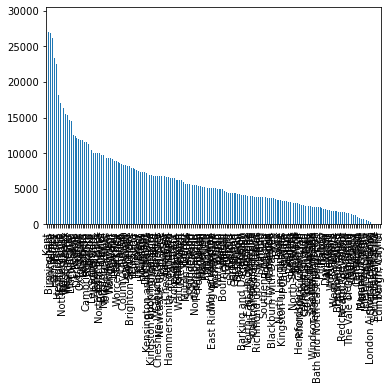

In [91]:
traffic_data['local_authority_(highway)'].value_counts().plot.bar()

To do: get population data for normalisation, normalise road type

In [ ]:
pop_data = pd.read_excel(io='table2.xls',
                         sheet_name='Persons',
                         header = 6,
                         usecols)

In [81]:
 gdf = gpd.read_file('Local_Authority_Districts__December_2019__Boundaries_UK_BFE-shp/Local_Authority_Districts__December_2019__Boundaries_UK_BFE.shp')

In [11]:
traffic_data[traffic_data.road_type=='Dual carriageway'][['1st_road_class']].value_counts()

1st_road_class
A                 95147
Unclassified       9032
B                  5970
Motorway           5969
C                  2868
A(M)                575
dtype: int64

In [13]:
traffic_data.isna().sum()

accident_index                                 0
1st_road_class                                 0
1st_road_number                                0
2nd_road_class                                 0
2nd_road_number                                0
accident_severity                              0
carriageway_hazards                            0
date                                           0
day_of_week                                    0
did_police_officer_attend_scene_of_accident    0
junction_control                               0
junction_detail                                0
latitude                                       0
light_conditions                               0
local_authority_(district)                     0
local_authority_(highway)                      0
location_easting_osgr                          0
location_northing_osgr                         0
longitude                                      0
lsoa_of_accident_location                      0
number_of_casualties

<AxesSubplot:>

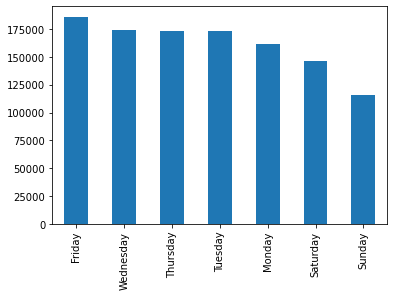

In [31]:
traffic_data['day_of_week'].value_counts().plot(kind='bar')


In [32]:
traffic_data['2nd_road_class'].unique()

array(['C', 'Unclassified', 'B', 'A', 'Motorway', 'A(M)'], dtype=object)